<a href="https://colab.research.google.com/github/ihstepura/publicgenai/blob/main/TASK_10_HERE_Copy_of_MLM2_OCR_with_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why Modern VLMs Excel for Real-World Receipts

Modern Vision-Language Models (VLMs) like Google Gemini, GPT-4V, or Claude 3  are pre-trained on vast and diverse datasets encompassing both images and text, allowing them to develop a much broader understanding of visual and linguistic concepts. They can understand and reason about images and text in a more general, open-ended, and human-like way, rather than relying on rigid patterns learned from specific document types.

The key advantages of using VLMs for real-world receipts include:

1.  **Better Generalization**: VLMs are inherently more robust to variations in layout, font, language, and content. Their extensive pre-training enables them to process receipts from virtually any source without requiring explicit fine-tuning for each specific layout or design.
2.  **Improved Handling of Noisy or Unstructured Data**: Unlike template-based OCR systems or models heavily reliant on learned document structures, VLMs can often make sense of incomplete, messy, or semi-structured data, inferring meaning from context and visual cues.
3.  **Semantic Understanding**: VLMs move beyond mere character recognition or pattern matching. They understand the *semantics* of the information on a receipt. For instance, they can identify 'total amount' even if it's labeled differently (e.g., 'Grand Total', 'Amount Due', 'Sum') or placed in an unusual location, because they grasp the underlying financial concept.
4.  **Zero-Shot/Few-Shot Learning**: With strong prompting, VLMs can often perform extraction tasks without any specific training examples for a given receipt type, or with very few examples, making them highly adaptable to new data streams.

In essence, VLMs offer a flexible, intelligent, and scalable solution for the unpredictable nature of real-world financial documents, making them ideal for practical FinTech applications.

## Setup Gemini API Key

#### Instructions
1. Go to the Google AI Studio website (https://aistudio.google.com/app/apikey) to generate an API key. Make sure you are logged in with your Google account.
2. Click 'Create API key in new project' or 'Get API Key' to generate a new key.
3. Once generated, copy the API key.
4. In Google Colab, click on the 'Secrets' tab (🔑 icon on the left sidebar).
5. Click 'Add new secret'.
6. For the 'Name' field, type `GOOGLE_API_KEY`.
7. For the 'Value' field, paste the API key you copied from Google AI Studio.
8. Ensure the 'Notebook access' checkbox is enabled for this secret.
9. In a new code cell, add the following Python code to load the API key from Colab secrets: `from google.colab import userdata` followed by `GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')`.
10. Finally, set the environment variable for the Gemini API by running `os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY`.

This code cell loads the API key from Colab secrets and sets it as an environment variable for the Gemini API.

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

NameError: name 'os' is not defined

In [ ]:
from google.colab import userdata
import os

# Load the API key from Colab secrets, assuming it's stored as 'GOOGLE_API_KEY'
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# Set the environment variable for the Gemini API
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

print("API key loaded and environment variable set.")

API key loaded and environment variable set.


This code block imports the `google.generativeai` library and then lists all available Gemini models, filtering for those that support content generation. This helps identify which models can be used for tasks like receipt analysis.

In [ ]:
import google.generativeai as genai

print("Listing available Gemini models:")
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(f"Name: {m.name}, Description: {m.description}")

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


Listing available Gemini models:
Name: models/gemini-2.5-flash, Description: Stable version of Gemini 2.5 Flash, our mid-size multimodal model that supports up to 1 million tokens, released in June of 2025.
Name: models/gemini-2.5-pro, Description: Stable release (June 17th, 2025) of Gemini 2.5 Pro
Name: models/gemini-2.0-flash, Description: Gemini 2.0 Flash
Name: models/gemini-2.0-flash-001, Description: Stable version of Gemini 2.0 Flash, our fast and versatile multimodal model for scaling across diverse tasks, released in January of 2025.
Name: models/gemini-2.0-flash-exp-image-generation, Description: Gemini 2.0 Flash (Image Generation) Experimental
Name: models/gemini-2.0-flash-lite-001, Description: Stable version of Gemini 2.0 Flash-Lite
Name: models/gemini-2.0-flash-lite, Description: Gemini 2.0 Flash-Lite
Name: models/gemini-exp-1206, Description: Experimental release (March 25th, 2025) of Gemini 2.5 Pro
Name: models/gemini-2.5-flash-preview-tts, Description: Gemini 2.5 Flash 

This cell initializes the `gemini_pro_vision` model using the `gemini-2.5-flash` model, preparing it for image and text content generation tasks.

In [ ]:
# Initialize the Gemini Pro Vision model with the updated name
gemini_pro_vision = genai.GenerativeModel('gemini-2.5-flash')

print("Google Gemini 2.5 Flash model initialized.")

Google Gemini 2.5 Flash model initialized.


This code loads an image from the specified path `/content/receipt1.jpg` into a PIL Image object and then displays it.

Image '/content/receipt1.jpg' loaded successfully.


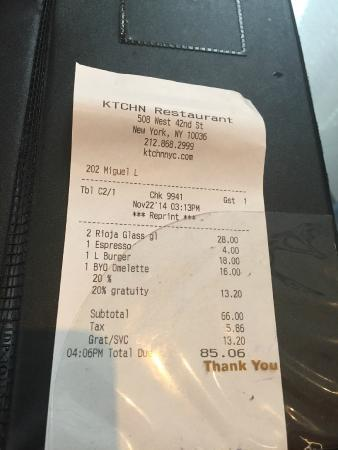

In [ ]:
from PIL import Image
# Load the image from the specified path
receipt_image_path = '/content/receipt1.jpg'
receipt_image = Image.open(receipt_image_path)
print(f"Image '{receipt_image_path}' loaded successfully.")
display(receipt_image)

This code block defines a detailed prompt for the Gemini VLM, instructing it to extract specific information from a receipt image into a structured JSON format. It then prepares the image and sends the request to the Gemini API, finally parsing and printing the structured response.

In [ ]:
import io
from PIL import Image
import json # Import json at the top for clarity and consistency

# Define a detailed prompt string for the Gemini VLM
prompt = """
Analyze this receipt image and extract the following information in a structured JSON format.
Ensure that all numerical values are returned as numbers (float or int), not strings.

Extract:
- "store_name": The name of the store.
- "date": The date of the transaction in YYYY-MM-DD format.
- "time": The time of the transaction in HH:MM format (24-hour).
- "items": A list of individual items purchased. Each item should be an object with:
    - "description": Name of the item.
    - "quantity": Number of units purchased (integer).
    - "unit_price": Price per unit (float).
    - "total_price": Total price for that item (float).
- "subtotal": The subtotal amount before tax (float).
- "tax": The tax amount (float).
- "total_amount": The final total amount paid (float).
- "currency": The currency symbol or code (e.g., "USD", "$").

If any information is not present, use null for its value.

Example JSON structure:
{
  "store_name": "Example Store",
  "date": "2023-10-26",
  "time": "14:30",
  "items": [
    {
      "description": "Item A",
      "quantity": 1,
      "unit_price": 10.50,
      "total_price": 10.50
    },
    {
      "description": "Item B",
      "quantity": 2,
      "unit_price": 5.25,
      "total_price": 10.50
    }
  ],
  "subtotal": 21.00,
  "tax": 1.50,
  "total_amount": 22.50,
  "currency": "$"
}
"""

# Convert receipt_image (which is an MPOImageFile) to JPEG bytes
img_byte_arr = io.BytesIO()
receipt_image.save(img_byte_arr, format='JPEG')
img_byte_arr = img_byte_arr.getvalue()

# 3. Create a content list containing the prompt and the converted image
contents = [prompt, {"mime_type": "image/jpeg", "data": img_byte_arr}]

# 4. Call the gemini_pro_vision.generate_content() method
print("Sending request to Gemini Pro Vision model...")
response = gemini_pro_vision.generate_content(contents)

# 5. Access the text part of the response
response_text = response.text

# 6. Print the raw text response
print("\n--- Raw Gemini Response ---")
print(response_text)
print("---------------------------")

# 7. Attempt to parse the response.text as a JSON object
try:
    # Clean the response_text to remove markdown code block fences if present
    if response_text.startswith('```json') and response_text.endswith('```'):
        cleaned_response_text = response_text.lstrip('```json').rstrip('```').strip()
    else:
        cleaned_response_text = response_text.strip()

    structured_data = json.loads(cleaned_response_text)
    print("\n--- Parsed Structured Data (JSON) ---")
    print(json.dumps(structured_data, indent=2))
    print("-------------------------------------")
except json.JSONDecodeError as e:
    print(f"\nError decoding JSON from Gemini output: {e}")
    print("Raw response could not be parsed as valid JSON. Check the output above for format issues.")

Sending request to Gemini Pro Vision model...

--- Raw Gemini Response ---
```json
{
  "store_name": "KTCHN Restaurant",
  "date": "2014-11-22",
  "time": "15:13",
  "items": [
    {
      "description": "Rioja Glass",
      "quantity": 2,
      "unit_price": 14.00,
      "total_price": 28.00
    },
    {
      "description": "Espresso",
      "quantity": 1,
      "unit_price": 4.00,
      "total_price": 4.00
    },
    {
      "description": "L Burger",
      "quantity": 1,
      "unit_price": 18.00,
      "total_price": 18.00
    },
    {
      "description": "BYO Omelette",
      "quantity": 1,
      "unit_price": 16.00,
      "total_price": 16.00
    }
  ],
  "subtotal": 66.00,
  "tax": 5.86,
  "total_amount": 85.06,
  "currency": "$"
}
```
---------------------------

--- Parsed Structured Data (JSON) ---
{
  "store_name": "KTCHN Restaurant",
  "date": "2014-11-22",
  "time": "15:13",
  "items": [
    {
      "description": "Rioja Glass",
      "quantity": 2,
      "unit_price": 1

This cell loads the `naver-clova-ix/cord-v2` dataset using the `datasets` library.

In [ ]:
from datasets import load_dataset

ds = load_dataset("naver-clova-ix/cord-v2")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-b4aaeceff1d90e(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00004-7dbbe248962764(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00002-of-00004-688fe1305a55e5(…):   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00003-of-00004-2d0cd200555ed7(…):   0%|          | 0.00/456M [00:00<?, ?B/s]

data/validation-00000-of-00001-cc3c5779f(…):   0%|          | 0.00/242M [00:00<?, ?B/s]

data/test-00000-of-00001-9c204eb3f4e1179(…):   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

This cell displays the dataset object, showing its structure and the available splits (train, validation, test) along with their features and number of rows.

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

This code cell simply prints the total number of records available in the training split of the dataset, providing a quick overview of its size.

In [ ]:
len(ds['train'])

800

This cell converts the first 5 records of the training dataset into a Pandas DataFrame and displays it, allowing for a quick inspection of the data structure and content, including the image and ground truth JSON.

In [ ]:
import pandas as pd
pd.DataFrame(ds['train'][:5])

image  \
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
1  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
2  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
3  <PIL.PngImagePlugin.PngImageFile image mode=RG...   
4  <PIL.PngImagePlugin.PngImageFile image mode=RG...   

                                        ground_truth  
0  {"gt_parse": {"menu": [{"nm": "Nasi Campur Bal...  
1  {"gt_parse": {"menu": [{"nm": "SPGTHY BOLOGNAS...  
2  {"gt_parse": {"menu": [{"nm": "HAKAU UDANG", "...  
3  {"gt_parse": {"menu": [{"nm": "Bintang Bremer"...  
4  {"gt_parse": {"menu": {"nm": "BASO BIHUN", "un...

This extensive code block is responsible for displaying the first 5 images and their corresponding ground truth data from the training set. It dynamically generates an HTML table with base64 encoded images and pretty-printed JSON ground truth for better visualization.

Displaying the first 5 images and their ground truth in a table:



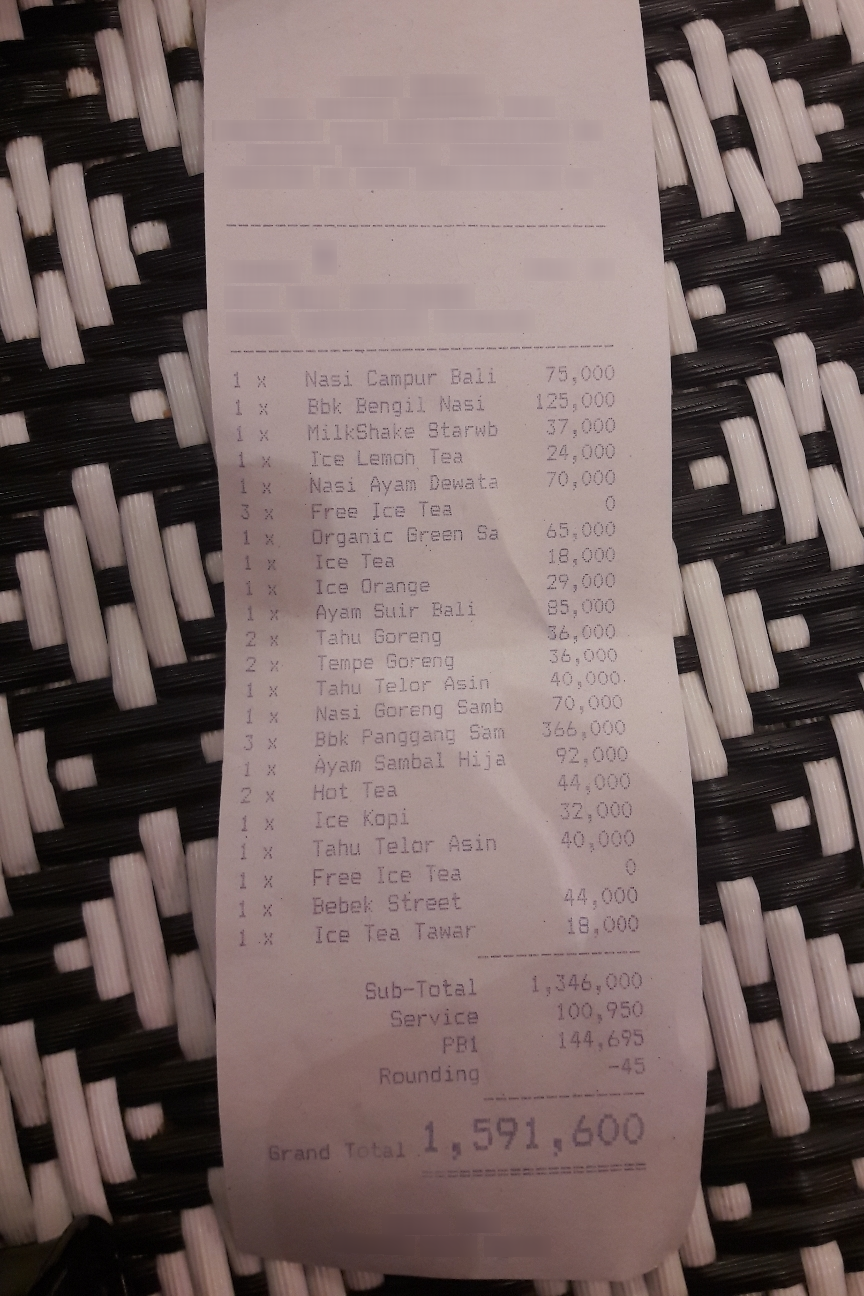
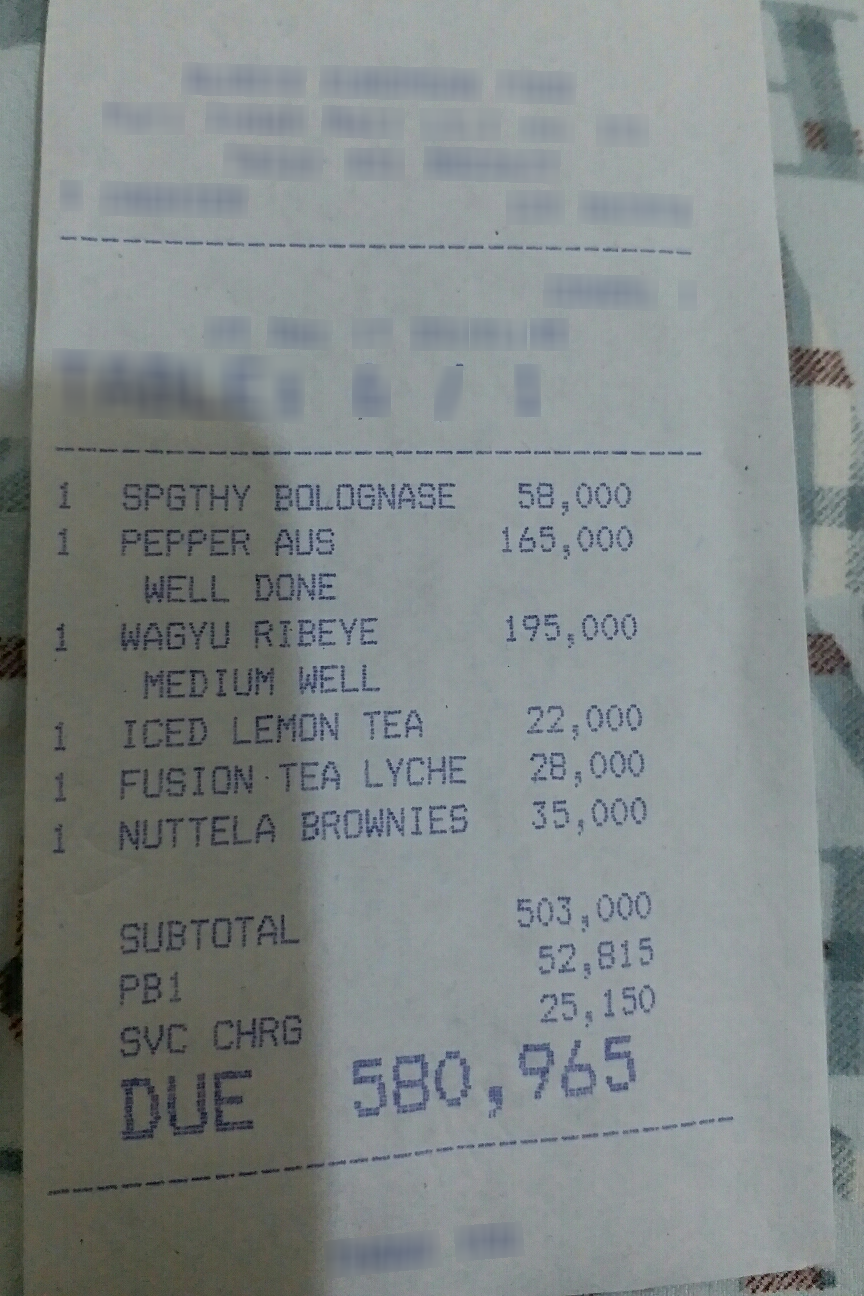
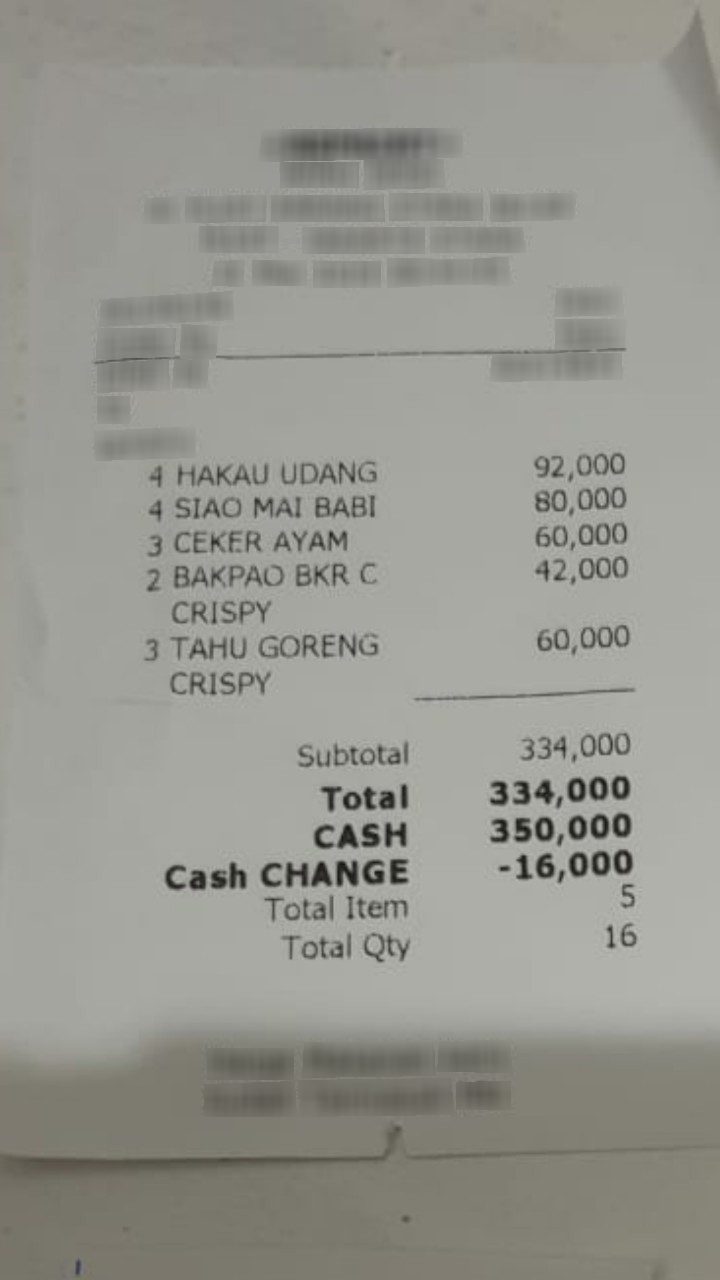
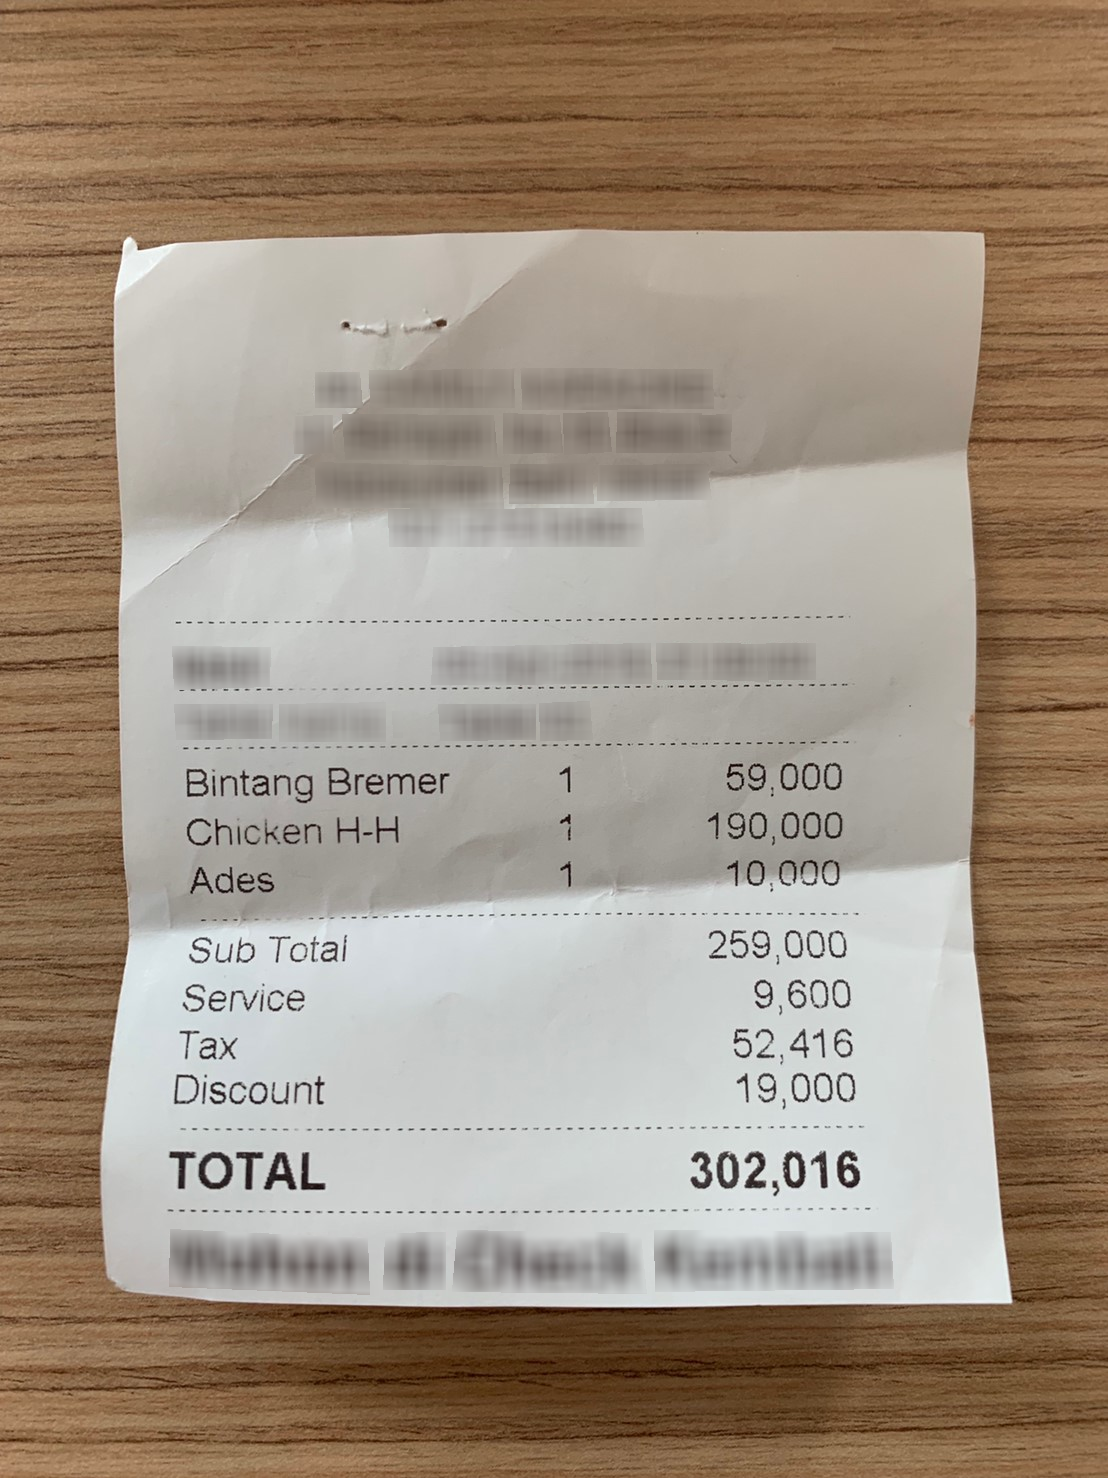
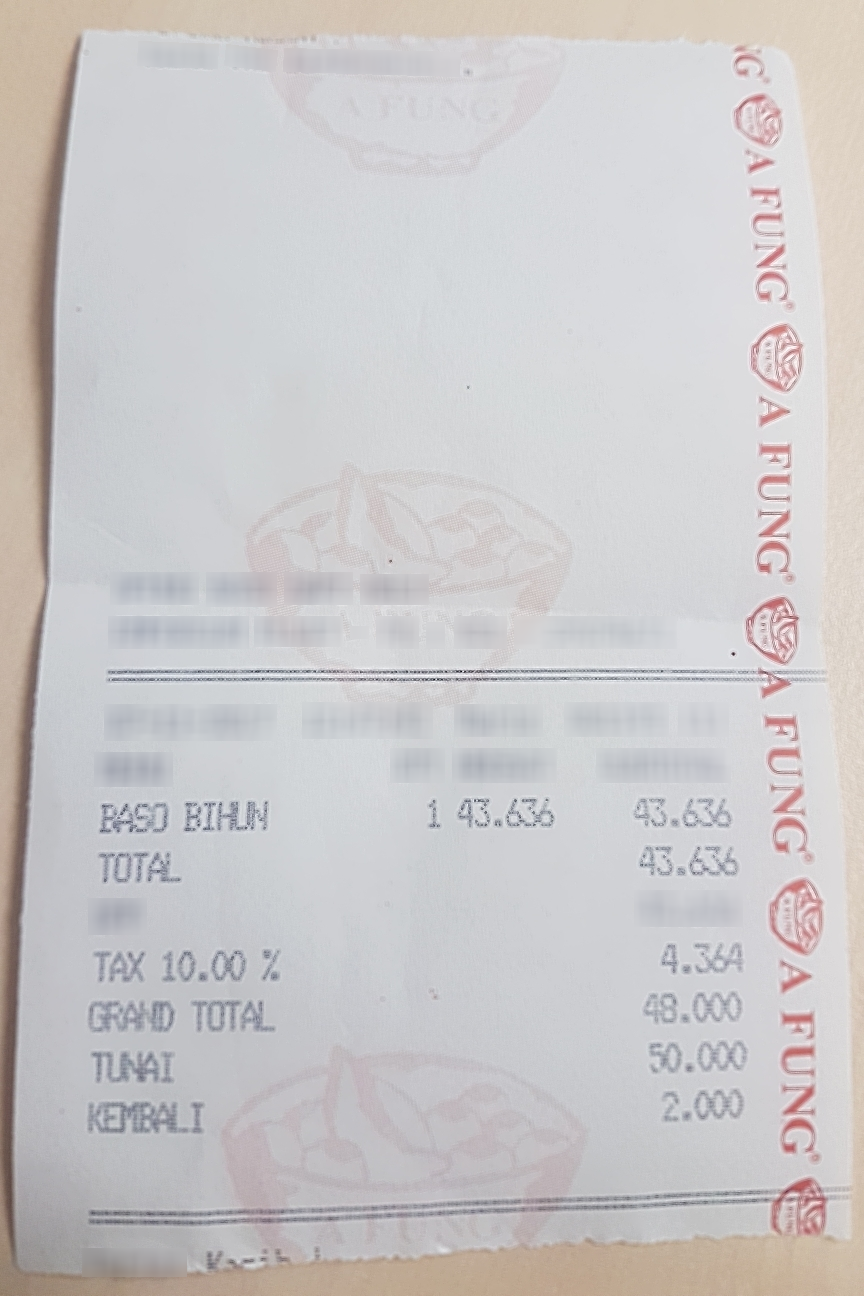

In [ ]:
from IPython.display import display, HTML
import pandas as pd
import json
import io
import base64

# Assuming the DataFrame with the first 5 rows is named 'df_first_5'
# from the previous execution of cell NypN9z20Mm4E.
# If not, let's re-create it here for clarity:
df_first_5 = pd.DataFrame(ds['train'][:5])

print("Displaying the first 5 images and their ground truth in a table:")

html_output = """
<style>
  table {
    border-collapse: collapse;
    width: 100%;
  }
  th, td {
    border: 1px solid #ddd;
    padding: 8px;
    text-align: left;
    vertical-align: top;
  }
  th {
    background-color: #f2f2f2;
  }
  img {
    max-width: 300px; /* Limit image width */
    height: auto;
    display: block; /* Remove extra space below image */
  }
  pre {
    white-space: pre-wrap; /* Preserve whitespace and wrap text */
    word-wrap: break-word;
  }
</style>
<table>
  <tr>
    <th>Image</th>
    <th>Ground Truth</th>
  </tr>
"""

for i, row in df_first_5.iterrows():
    html_output += "<tr>"
    # Image column
    img_bytes = io.BytesIO()
    row['image'].save(img_bytes, format='PNG') # Save the PIL image to bytes
    img_base64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
    html_output += f"<td><img src='data:image/png;base64,{img_base64}' width='200'></td>"

    # Ground Truth column
    ground_truth_json = json.loads(row['ground_truth'])
    html_output += f"<td><pre>{json.dumps(ground_truth_json, indent=2)}</pre></td>"
    html_output += "</tr>"
html_output += "</table>"

display(HTML(html_output))

This code block defines the process of extracting the image, store name, and overall total price for each receipt in `ds['train']`. It cleans the total price string to ensure it can be converted to a float and then creates a DataFrame named `df_receipt_summary` with the extracted information.

In [ ]:
import pandas as pd
import json
import re # Import regular expression module

# Initialize an empty list to store the extracted data for each receipt
receipt_data_df = []

# Iterate through each record in ds['train']
for record in ds['train']:
    image = record['image']
    ground_truth_str = record['ground_truth']

    store_name = None
    total_price = None

    try:
        ground_truth_json = json.loads(ground_truth_str)
        gt_parse = ground_truth_json.get('gt_parse', {})

        # 5. Extract the store_name
        company_name = gt_parse.get('company', {}).get('name')
        seller_name = gt_parse.get('seller', {}).get('name')

        if company_name:
            store_name = company_name
        elif seller_name:
            store_name = seller_name

        # 6. Extract the total_price string
        total_info = gt_parse.get('total', {})
        total_price_str = total_info.get('total_price')

        # 7. Clean and convert total_price to float
        if total_price_str is not None and isinstance(total_price_str, str):
            # Remove any non-digit, non-decimal characters (e.g., currency symbols, spaces, thousands separators)
            # First, handle comma as decimal if present, convert to dot, then remove other non-digits except first dot
            cleaned_price = total_price_str.replace(',', '.')

            # If there are multiple dots (e.g., "1.234.567.89"), assume all but the last are thousands separators
            # and consolidate them into a single decimal point or remove.
            # A more robust way: keep digits and only one decimal point.
            parts = re.findall(r'\d+', cleaned_price) # Extract all number sequences
            if parts:
                numeric_string = ''.join(parts)
                # Find the last potential decimal separator
                last_dot_index = cleaned_price.rfind('.')
                if last_dot_index != -1 and last_dot_index > cleaned_price.rfind(parts[-1]): # Check if it's actually a decimal after the last number
                    # Reconstruct with the decimal point
                    integer_part = ''.join(re.findall(r'\d', cleaned_price[:last_dot_index]))
                    decimal_part = ''.join(re.findall(r'\d', cleaned_price[last_dot_index+1:]))
                    cleaned_price = f"{integer_part}.{decimal_part}"
                else:
                    cleaned_price = numeric_string
            else:
                cleaned_price = ""

            try:
                if cleaned_price:
                    total_price = float(cleaned_price)
                else:
                    total_price = None
            except ValueError:
                total_price = None # Conversion failed

        # 8. Append extracted data to the list
        receipt_data_df.append({
            'image': image,
            'store_name': store_name,
            'total_price': total_price
        })

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for a record: {e}")
        continue # Skip to the next record if JSON is invalid
    except Exception as e:
        print(f"An unexpected error occurred for a record: {e}")
        continue # Skip to the next record if an error occurs

# Create the new DataFrame
df_receipt_summary = pd.DataFrame(receipt_data_df)

print(f"Created df_receipt_summary with {len(df_receipt_summary)} records.")
print("First 5 rows of df_receipt_summary:")
display(df_receipt_summary.head())

Created df_receipt_summary with 800 records.
First 5 rows of df_receipt_summary:


image store_name  total_price
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None    1591600.0
1  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None     580965.0
2  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None     334000.0
3  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None     302016.0
4  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None      48000.0

This cell assigns the `df_receipt_summary` DataFrame (created in the previous data extraction step) to `df_receipt`, as per the task instructions. It then prints the number of records and displays the head of `df_receipt` to verify its content and structure.

In [ ]:
df_receipt = df_receipt_summary

print(f"Number of records in df_receipt: {len(df_receipt)}")
print("First 5 rows of df_receipt:")
display(df_receipt.head())

Number of records in df_receipt: 800
First 5 rows of df_receipt:


image store_name  total_price
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None    1591600.0
1  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None     580965.0
2  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None     334000.0
3  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None     302016.0
4  <PIL.PngImagePlugin.PngImageFile image mode=RG...       None      48000.0

This cell calculates and prints the number of records in the `df_receipt` DataFrame where the 'store_name' column has a `None` value. This is useful for understanding the completeness of the extracted store name data.

In [ ]:
num_none_store_name = df_receipt['store_name'].isnull().sum()
print(f"Number of records with None in 'store_name': {num_none_store_name}")

Number of records with None in 'store_name': 800


This cell removes the 'store_name' column from the `df_receipt` DataFrame, as it was found to be entirely `None`. It then displays the head of the DataFrame to confirm the column's removal.

In [ ]:
df_receipt = df_receipt.drop(columns=['store_name'])
print(" 'store_name' column removed from df_receipt.")
print("First 5 rows of df_receipt after column removal:")
display(df_receipt.head())

 'store_name' column removed from df_receipt.
First 5 rows of df_receipt after column removal:


image  total_price
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...    1591600.0
1  <PIL.PngImagePlugin.PngImageFile image mode=RG...     580965.0
2  <PIL.PngImagePlugin.PngImageFile image mode=RG...     334000.0
3  <PIL.PngImagePlugin.PngImageFile image mode=RG...     302016.0
4  <PIL.PngImagePlugin.PngImageFile image mode=RG...      48000.0

#Required Task 10
Your task is to utilize the Gemini VLM to predict the `total_price` for a subset of receipts and then evaluate the model's performance against the ground truth `total_price` already present in `df_receipt`.

#### Instructions:

1.  **Randomly Select 15 Records**:
    *   From the `df_receipt` DataFrame, randomly select 100 receipts. This will be your test set for Gemini's prediction.
    *   Store these 15 records in a new DataFrame, say `df_test_receipts`.

2.  **Define a Prompt for Gemini**:
    *   Create a clear and concise prompt that instructs Gemini to extract only the `total_price` from a given receipt image. Emphasize that the output should be a single numerical value (float).
    *   Example prompt: `"Extract the total amount from this receipt. Provide only the numerical value as a float."`

3.  **Process `df_test_receipts` with Gemini**:
    *   Iterate through each row in `df_test_receipts`.
    *   For each receipt's image, call the Gemini VLM with your defined prompt.
    *   Parse Gemini's response to extract the predicted `total_price`. Handle potential errors (e.g., non-numeric responses, API issues) by assigning `None` or `NaN` if a valid price cannot be extracted.
    *   Add the extracted prediction as a new column, `predicted_total_price`, to `df_test_receipts`.

4.  **Evaluate Predictions**:
    *   Compare the `predicted_total_price` with the `total_price` (ground truth) in `df_test_receipts`.
    *   Calculate appropriate evaluation metrics. Consider the following:
        *   **Mean Absolute Error (MAE)**: Average of the absolute differences between predicted and actual values.
        *   **Number of successful extractions**: Count how many predictions were successfully extracted (not `None` or `NaN`).
        *   **Accuracy within a threshold**: Calculate the percentage of predictions that are within a certain percentage (e.g., 5% or 10%) of the ground truth.

5.  **Display Results**:
    *   Print the calculated evaluation metrics.
    *   Display `df_test_receipts` with `total_price` and `predicted_total_price` columns for a few sample rows to show the comparison.


In [ ]:
#TASK 10
#I have learned how to extract data from photos with Google VLM.
#This task taught me how to extract all the data from the photos of receipts. I understood that AI is advanced that is able to analyze photos of receipts.

# Task
Randomly select 15 records from the `df_receipt` DataFrame and store them in a new DataFrame named `df_test_receipts_1`, then display the first few rows of `df_test_receipts_1`.

## Select Random Receipts

### Subtask:
Randomly select 15 records from the `df_receipt` DataFrame and store them in a new DataFrame named `df_test_receipts_1`.


**Reasoning**:
I will randomly select 15 records from the `df_receipt` DataFrame and store them in a new DataFrame named `df_test_receipts_1` as per the subtask instructions.



In [43]:
df_test_receipts_1 = df_receipt.sample(n=15, random_state=42)
print(f"Selected {len(df_test_receipts_1)} random receipts for testing.")
display(df_test_receipts_1.head())

Selected 15 random receipts for testing.


image  total_price
696  <PIL.PngImagePlugin.PngImageFile image mode=RG...      52500.0
667  <PIL.PngImagePlugin.PngImageFile image mode=RG...     105999.0
63   <PIL.PngImagePlugin.PngImageFile image mode=RG...      23600.0
533  <PIL.PngImagePlugin.PngImageFile image mode=RG...      60000.0
66   <PIL.PngImagePlugin.PngImageFile image mode=RG...      57900.0

## Final Task

### Subtask:
Confirm the creation and content of `df_test_receipts_1` with the randomly selected receipts.


In [47]:
display(df_test_receipts_1)

image  total_price
696  <PIL.PngImagePlugin.PngImageFile image mode=RG...      52500.0
667  <PIL.PngImagePlugin.PngImageFile image mode=RG...     105999.0
63   <PIL.PngImagePlugin.PngImageFile image mode=RG...      23600.0
533  <PIL.PngImagePlugin.PngImageFile image mode=RG...      60000.0
66   <PIL.PngImagePlugin.PngImageFile image mode=RG...      57900.0
621  <PIL.PngImagePlugin.PngImageFile image mode=RG...      80000.0
346  <PIL.PngImagePlugin.PngImageFile image mode=RG...      45000.0
490  <PIL.PngImagePlugin.PngImageFile image mode=RG...          NaN
760  <PIL.PngImagePlugin.PngImageFile image mode=RG...      28000.0
456  <PIL.PngImagePlugin.PngImageFile image mode=RG...     159638.0
65   <PIL.PngImagePlugin.PngImageFile image mode=RG...     650100.0
286  <PIL.PngImagePlugin.PngImageFile image mode=RG...      14000.0
635  <PIL.PngImagePlugin.PngImageFile image mode=RG...     111000.0
67   <PIL.PngImagePlugin.PngImageFile image mode=RG...      65000.0
327  <PIL.PngImagePlugin.PngImageFile image mode=RG...      39600.0

The following prompt will be used to extract the total amount from the receipt image.

"Extract the total amount from this receipt. Provide only the numerical value as a float."

# Task
Extract the `total_price` as a numerical float from each receipt image in `df_test_receipts_1` using the Gemini Vision Language Model, then update `df_test_receipts_1` with these predictions and display the original and predicted total prices.

## Define Gemini Prompt

### Subtask:
Define the clear and concise prompt string that instructs Gemini to extract only the 'total_price' as a numerical float from a given receipt image. This prompt will be used for all subsequent Gemini API calls.


**Reasoning**:
To define the prompt string for the Gemini VLM, I will create a Python code block that assigns the specified prompt text to the `total_price_prompt` variable.



In [48]:
total_price_prompt = "Extract the total amount from this receipt. Provide only the numerical value as a float, without any additional text or formatting. If the total amount is not found, return null."
print("Gemini prompt for total price extraction defined.")

Gemini prompt for total price extraction defined.


**Reasoning**:
Now that the prompt is defined, the next step is to process each image in `df_test_receipts_1` using the Gemini VLM to extract the predicted `total_price`. This involves iterating through the DataFrame, converting each PIL Image to bytes, calling the Gemini API with the prompt and image, parsing the response, and storing the prediction.



In [53]:
import io
from PIL import Image
import json
import time
import re
from google.api_core import exceptions

# Ensure predicted_prices list is re-initialized or cleared if re-running
# If re-running this cell, clear previous predictions from the DataFrame as well
if 'predicted_total_price' in df_test_receipts_1.columns:
    df_test_receipts_1 = df_test_receipts_1.drop(columns=['predicted_total_price'])

predicted_prices = []

for index, row in df_test_receipts_1.iterrows():
    image = row['image']

    # Convert PIL Image to JPEG bytes
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()

    # Prepare content for Gemini API
    contents = [total_price_prompt, {"mime_type": "image/jpeg", "data": img_byte_arr}]

    predicted_total_price = None
    retries = 0
    max_retries = 5
    base_delay = 10 # seconds

    while retries < max_retries:
        try:
            response = gemini_pro_vision.generate_content(contents)
            response_text = response.text.strip()

            # Attempt to parse the response as a float
            if response_text.lower() == 'null':
                predicted_total_price = None
            else:
                # Clean response: remove any characters that are not digits or a single dot
                # Handle cases like "$123.45", "1,234.56", "123.45."
                # First, ensure only one decimal point, and remove other non-numeric chars
                cleaned_response = re.sub(r'[^-0-9.]', '', response_text) # Keep digits, dot, and negative sign
                # Handle multiple decimal points by keeping the last one (common for currency parsing)
                if cleaned_response.count('.') > 1:
                    parts = cleaned_response.split('.')
                    cleaned_response = parts[0] + '.' + ''.join(parts[1:])

                predicted_total_price = float(cleaned_response)
            break # Break out of retry loop if successful
        except exceptions.ResourceExhausted as e:
            retries += 1
            delay = base_delay * (2 ** (retries - 1)) # Exponential backoff
            print(f"Quota exceeded for index {index}. Retrying in {delay} seconds. ({retries}/{max_retries})")
            time.sleep(delay)
            if retries == max_retries:
                print(f"Max retries reached for index {index}. Assigning None.")
                predicted_total_price = None
        except Exception as e:
            print(f"Error processing image at index {index}: {e}. Response text: {response_text}")
            predicted_total_price = None # Assign None if an error occurs or parsing fails
            break # Break out of retry loop for other errors

    predicted_prices.append(predicted_total_price)

# Add the predictions as a new column to df_test_receipts_1
df_test_receipts_1['predicted_total_price'] = predicted_prices

print("Gemini predictions completed and added to 'df_test_receipts_1'.")
print("Displaying actual vs. predicted total prices for the test set:")
display(df_test_receipts_1[['total_price', 'predicted_total_price']])

Gemini predictions completed and added to 'df_test_receipts_1'.
Displaying actual vs. predicted total prices for the test set:


total_price  predicted_total_price
696      52500.0                52500.0
667     105999.0               105999.0
63       23600.0                23600.0
533      60000.0                60000.0
66       57900.0                   57.9
621      80000.0                80000.0
346      45000.0                45000.0
490          NaN               250000.0
760      28000.0                28000.0
456     159638.0               159638.0
65      650100.0                  650.1
286      14000.0                14000.0
635     111000.0               111000.0
67       65000.0                   65.0
327      39600.0                39600.0

# Task
Summarize the evaluation results of the Gemini VLM's `total_price` predictions.

## Evaluate Predictions

### Subtask:
Calculate the Mean Absolute Error (MAE) between `total_price` and `predicted_total_price`. Count the number of successful extractions (where `predicted_total_price` is not null). Calculate the accuracy within a 10% threshold, meaning the percentage of predictions where the absolute difference between `total_total_price` and `predicted_total_price` is less than or equal to 10% of the `total_price`.


**Reasoning**:
To calculate the required evaluation metrics, I need to import the `numpy` library, filter the DataFrame for valid predictions, and then apply mathematical operations as specified in the instructions for MAE, successful extractions, and 10% threshold accuracy.



In [55]:
import numpy as np

# 1. Create a new DataFrame or filter df_test_receipts_1 for evaluation
df_eval = df_test_receipts_1.dropna(subset=['total_price', 'predicted_total_price']).copy()

# 2. Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(df_eval['total_price'] - df_eval['predicted_total_price']))

# 3. Count successful extractions (non-null predicted_total_price)
num_successful_extractions = df_test_receipts_1['predicted_total_price'].count()

# 4. Calculate accuracy within a 10% threshold
# Absolute difference between predicted and actual values
df_eval['abs_diff'] = np.abs(df_eval['predicted_total_price'] - df_eval['total_price'])

# 10% threshold of the actual total_price
df_eval['threshold_10_percent'] = 0.10 * df_eval['total_price']

# Count predictions within the 10% threshold
num_accurate_predictions = (df_eval['abs_diff'] <= df_eval['threshold_10_percent']).sum()

# Calculate accuracy percentage
accuracy_10_percent = (num_accurate_predictions / len(df_eval)) * 100 if len(df_eval) > 0 else 0

print(f"Evaluation Metrics for Gemini VLM Total Price Prediction (on {len(df_eval)} records with valid predictions):\n")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Number of Successful Extractions (out of {len(df_test_receipts_1)} attempts): {num_successful_extractions}")
print(f"Accuracy within 10% Threshold: {accuracy_10_percent:.2f}%")

Evaluation Metrics for Gemini VLM Total Price Prediction (on 14 records with valid predictions):

Mean Absolute Error (MAE): 55159.07
Number of Successful Extractions (out of 15 attempts): 15
Accuracy within 10% Threshold: 78.57%


In [56]:
print("Comparison of Actual vs. Predicted Total Prices (Sample Rows):")
display(df_test_receipts_1[['total_price', 'predicted_total_price']].head())

Comparison of Actual vs. Predicted Total Prices (Sample Rows):


total_price  predicted_total_price
696      52500.0                52500.0
667     105999.0               105999.0
63       23600.0                23600.0
533      60000.0                60000.0
66       57900.0                   57.9

## Final Task

### Subtask:
Summarize the evaluation results of the Gemini VLM's `total_price` predictions.


## Summary:

### Q&A
The evaluation results for the Gemini VLM's `total_price` predictions indicate a Mean Absolute Error (MAE) of 55159.07. The model successfully extracted `total_price` for all 15 attempts. Furthermore, the accuracy within a 10% threshold was 78.57%.

### Data Analysis Key Findings
*   The evaluation was conducted on 14 records where both actual and predicted `total_price` values were available.
*   The Mean Absolute Error (MAE) between the actual `total_price` and the `predicted_total_price` was found to be 55159.07.
*   There were 15 successful extractions of `predicted_total_price` out of 15 attempts, indicating a 100% extraction rate.
*   The accuracy of predictions falling within a 10% threshold of the actual `total_price` was 78.57%.

### Insights or Next Steps
*   Investigate the specific instances contributing to the high Mean Absolute Error (\$55159.07), as this could indicate outliers or systematic errors in predicting certain types of `total_price` values, especially given the decent 10% accuracy.
*   While the 100% extraction rate is excellent, further analysis could involve examining the distribution of errors to determine if the model performs better or worse for different price ranges or receipt characteristics.
